Imports and data.

In [258]:
%reload_ext autoreload
%autoreload 2

import rdkit
rdkit.Chem.Draw.IPythonConsole.ipython_maxProperties = -1

import dgym as dg

# load all data
print('load data')
path = '../../dgym-data'

deck = dg.MoleculeCollection.load(
    f'{path}/DSi-Poised_Library_annotated.sdf',
    reactant_names=['reagsmi1', 'reagsmi2', 'reagsmi3']
)

reactions = dg.ReactionCollection.from_json(
    path = f'{path}/All_Rxns_rxn_library.json',
    smarts_col = 'reaction_string',
    classes_col = 'functional_groups'
)
reactions = dg.collection.ReactionCollection([dg.reaction.LazyReaction(r.template, id=r.id) for r in reactions])

building_blocks = dg.datasets.disk_loader(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630.sdf')
fingerprints = dg.datasets.fingerprints(f'{path}/out/Enamine_Building_Blocks_Stock_262336cmpd_20230630_atoms.fpb')

load data


Define library designer.

In [9]:
from dgym.envs.library_designer import LibraryDesigner

library_designer = LibraryDesigner(
    reactions,
    building_blocks,
    fingerprints
)

Reconstruct a molecule as a generator.

In [64]:
import inspect

def retrosynthesize(molecule):
    
    # Base cases
    if inspect.isgenerator(molecule):
        return molecule
    
    elif not molecule.reactants:
        return molecule
    
    # Recursive case: Reconstruct each reactant
    reconstructed_reactants = [reconstruct_molecule(reactant) for reactant in molecule.reactants]
        
    # Use the reaction to reconstruct the original molecule from its reactants
    output = molecule.reaction.run(reconstructed_reactants)
    return output

Define multi-step molecule.

In [65]:
from dgym.molecule import Molecule

multi_step_molecule = Molecule(
    'COc1cc2c(N(C(=O)c3ccnnc3)c3ccc4ncccc4c3)ncnc2cc1OCc1ccccc1',
    reaction = reactions['18_Halide_and_Amine'][0],
    reactants = [
        Molecule('COc1cc2c(Cl)ncnc2cc1OCc1ccccc1'),
        Molecule('O=C(Nc1ccc2ncccc2c1)c1ccnnc1',
                 reaction = reactions['13_Carboxylate_and_Amine'][0],
                 reactants = [Molecule('O=C(O)c1ccnnc1'), Molecule('Nc1ccc2ncccc2c1')]
        )
    ]
)

Enumerate molecules.

CPU times: user 106 ms, sys: 0 ns, total: 106 ms
Wall time: 114 ms


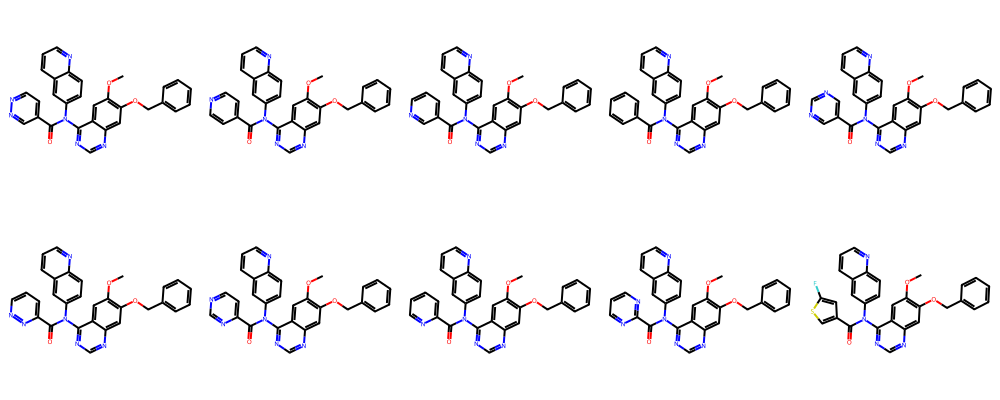

In [69]:
%%time
from copy import deepcopy

# Don't mutate the original molecule
copy_molecule = deepcopy(multi_step_molecule)

# Create an analog generator for one of the reactant's reactants
copy_molecule.reactants[1].reactants[0] = library_designer.generate_analogs(
    [copy_molecule.reactants[1].reactants[0]],
    temperature=0.0
)[0]

# Recursively derive lazy reaction
generator = retrosynthesize(copy_molecule)

# Run 10 calls to lazy reaction
results = [next(generator) for _ in range(10)]

# Visualize!
from rdkit.Chem.Draw import MolsToGridImage
MolsToGridImage([r.mol for r in results], molsPerRow=5)

### Construct logic of new Library Designer

In [223]:
import inspect

def retrosynthesize(molecule):
    
    # Base cases
    if inspect.isgenerator(molecule):
        return molecule
    
    elif not molecule.reactants:
        return molecule
    
    # Recursive case: Reconstruct each reactant
    reconstructed_reactants = [reconstruct_molecule(reactant) for reactant in molecule.reactants]
        
    # Use the reaction to reconstruct the original molecule from its reactants
    output = molecule.reaction.run(reconstructed_reactants)
    return output

def tag_reactants(reactants):
    """
    Tag every atom by its reactant of origin.
    
    """
    def _tag_reactant(idx, mol):
        for atom in mol.GetAtoms():
            atom.SetIntProp('reactant_idx', idx)
        return mol

    for idx, reactant in enumerate(reactants):
        reactant.mol = _tag_reactant(idx, reactant.mol)
        
    return reactants

In [577]:
%%time
import itertools

# Deepcopy original molecule
from copy import deepcopy
molecule = deepcopy(deck[0])

# Get matching reactions and corresponding reactants
system = library_designer.match_reactions(molecule)

# Perform reactions
protect = True
size = 5
products = []
for reaction, reactants in system:
    
    if protect:
        reactants = tag_reactants(reactants)
        
    # Replace a reactant with a generator
    reactants = library_designer.generate_analogs(reactants, temperature=0.0)

    # Run reaction
    output = reaction.run(reactants)
    while len(products) < size:
        products.append(next(output))

# from rdkit.Chem.Draw import MolsToGridImage
# MolsToGridImage([p.mol for p in products], molsPerRow=5)

CPU times: user 106 ms, sys: 177 µs, total: 106 ms
Wall time: 15.6 ms


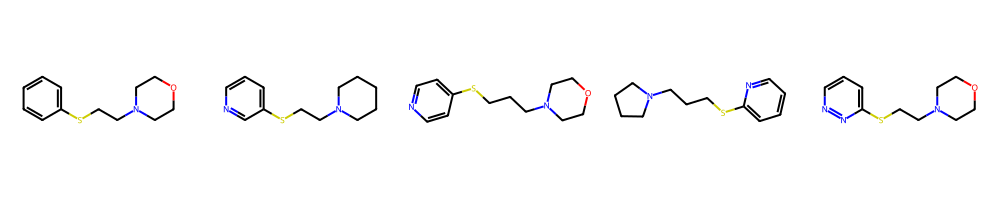

In [581]:
from rdkit.Chem.Draw import MolsToGridImage
MolsToGridImage([p.mol for p in products], molsPerRow=5)